# 1. 위도, 경도로 거리 구하는 프로그램

In [1]:
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    실제 km를 알고 싶다면 haversine 를 이용하고
    그렇지 않고 더 빠른 속도로 단순 비교를 위한 용도라면 euclidean 를 이용할 수 있다.
    
    인용: https://blog.naver.com/wideeyed/221406744173
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

In [2]:
GeoUtil.get_harversion_distance(126.97843, 37.56668, 127.02758, 37.49794) # 테스트
GeoUtil.get_harversion_distance(126.79, 33.33, 126.80, 33.33)
# (126.575167, 33.267433) -> (126.573495, 33.266232)
GeoUtil.get_harversion_distance(126.575167, 33.267433, 126.573495, 33.266232)
# (126.575167, 33.267433) -> (126.573495, 33.266232) | 13.50

0.20494

# 2. 각 정류장에 대해 
# 가장 인접한 정류장과의 거리 계산 프로그램
### 무언가 잘못되었다. km단위로 나올리가 없는데...

In [3]:
import sys

def get_dist_from_most_adjacent_station_per_each_station(df):
    local_X_list, local_Y_list = list(df['LOCAL_X']), list(df['LOCAL_Y'])
    local_list = [(local_X_list[i], local_Y_list[i]) for i in range(len(local_X_list))]
    
    min_dist_list = []

    for i in range(len(local_list)):
        minimum = sys.maxsize
        
        temp = 0
        
        for j in range(len(local_list)):
            if i == j:
                continue

            dist = GeoUtil.get_harversion_distance(local_list[i][0], local_list[i][1],
                                                   local_list[j][0], local_list[j][1])
            if minimum > dist:
                temp = j
                minimum = dist

        if dist == 0:
            print(i, j)

        dist = minimum
        min_dist_list.append(dist)

    min_dist_list.sort()
    min_dist_list = pd.Series(min_dist_list)
    
    return min_dist_list

# 3. 서귀포시 수행 결과

In [4]:
import pandas as pd

path = r'D:\jeju_bus_data_no_leakage\station'.replace('\\', '/')
result_path = r'C:\Users\think\Desktop\버스 정류장 클러스터링'.replace('\\', '/')

In [5]:
df = pd.read_csv(path + '/' + 'station_final.csv', encoding='ansi')

In [6]:
df['city'] = df['STATION_ADDR']
df.loc[:, 'city'] = df.loc[:, 'STATION_ADDR'].apply(lambda string: string.split(' ')[0])

In [7]:
jeju_city_station_df = df.query('city == "제주시"')

In [8]:
seogwipo_city_station_df = df.query('city == "서귀포시"')

In [9]:
import matplotlib.pyplot as plt

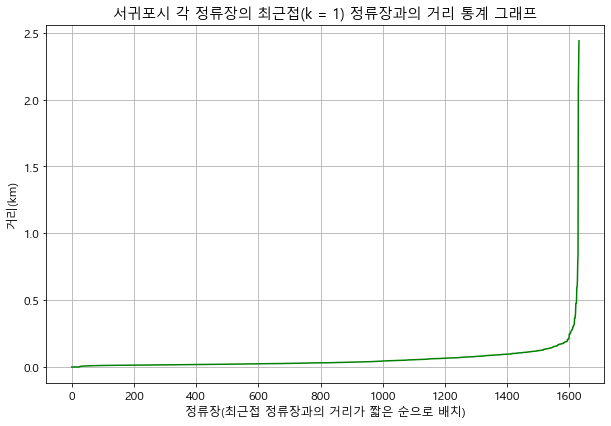

In [10]:
min_dist_list = get_dist_from_most_adjacent_station_per_each_station(seogwipo_city_station_df)

fig_title = '서귀포시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6.6))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(km)')
plt.plot(min_dist_list, color = 'green')
plt.gcf().savefig(result_path + '/' + fig_title)
plt.show()

In [11]:
min_dist_list.mean(), min_dist_list.max(), min_dist_list.min() # 단위: km

(0.05705143382352934, 2.44, 0.0)

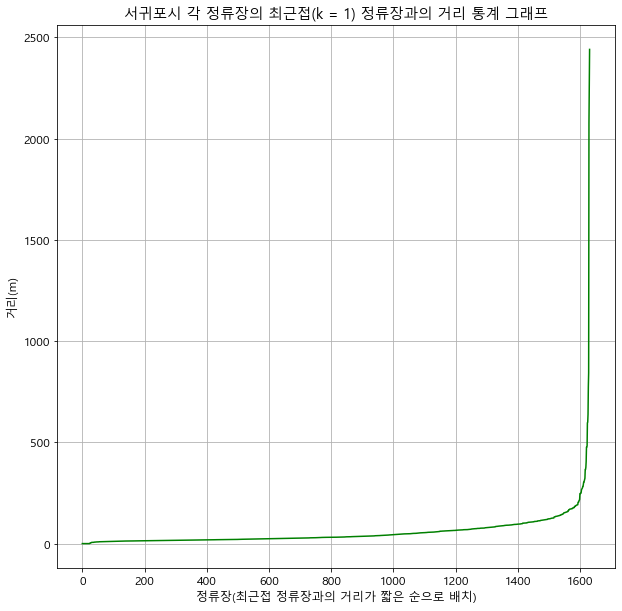

In [12]:
fig_title = '서귀포시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

min_dist_list = min_dist_list * 1000

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 10))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(m)')
plt.plot(min_dist_list, color = 'green')
plt.gcf().savefig(result_path + '/' + 'm단위 ' + fig_title)
plt.show()

# 3. 제주시 수행 결과

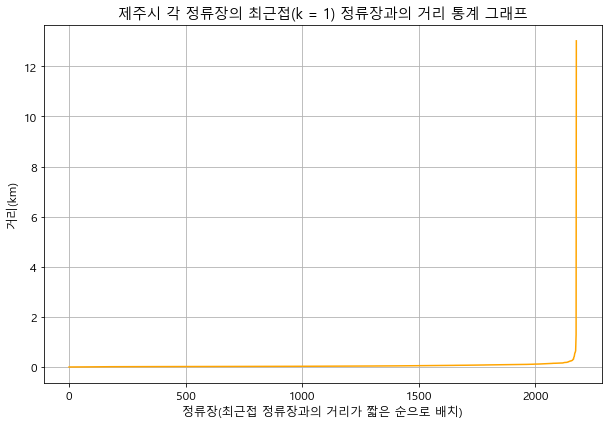

In [13]:
min_dist_list = get_dist_from_most_adjacent_station_per_each_station(jeju_city_station_df)

fig_title = '제주시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6.6))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(km)')
plt.plot(min_dist_list, color = 'orange')
plt.gcf().savefig(result_path + '/' + fig_title)
plt.show()

In [14]:
min_dist_list.mean(), min_dist_list.max(), min_dist_list.min() # 단위: km

(0.05567027089072537, 13.01806, 0.0)

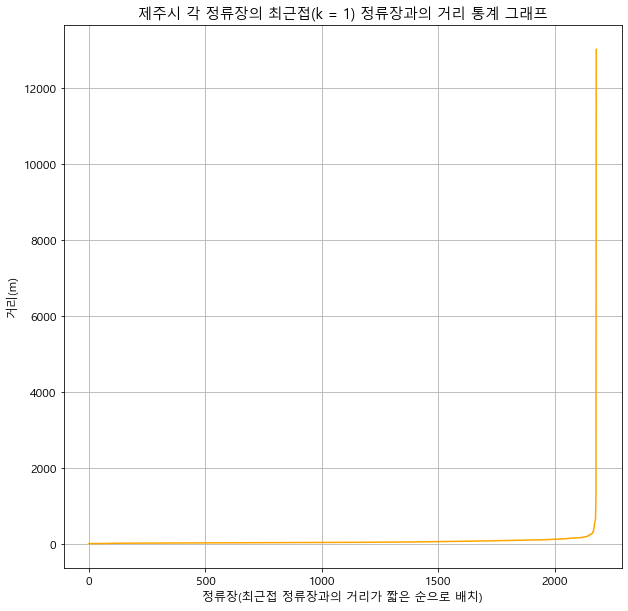

In [15]:
fig_title = '제주시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

min_dist_list = min_dist_list * 1000

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 10))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(m)')
plt.plot(min_dist_list, color = 'orange')
plt.gcf().savefig(result_path + '/' + 'm단위 ' + fig_title)
plt.show()

In [16]:
min_dist_list

0           0.00
1           0.00
2           0.00
3           0.00
4           0.00
5           0.00
6           0.00
7           0.00
8           0.00
9           0.00
10          0.00
11          0.00
12          0.00
13          0.00
14          0.00
15          0.00
16          0.00
17          0.00
18          0.00
19          0.00
20          0.00
21          0.00
22          0.00
23          0.00
24          0.00
25          0.00
26          0.00
27          0.00
28          0.00
29          0.00
          ...   
2148      229.44
2149      229.44
2150      231.56
2151      239.47
2152      239.47
2153      244.00
2154      244.59
2155      245.86
2156      245.87
2157      248.24
2158      259.81
2159      263.19
2160      267.20
2161      275.01
2162      292.86
2163      306.34
2164      314.05
2165      314.05
2166      380.97
2167      402.80
2168      418.83
2169      479.02
2170      531.83
2171      565.07
2172      580.04
2173      606.50
2174      645.57
2175      987.